In [1]:
import os
import json
import random
import numpy as np
from six.moves import range

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk

import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision

import lc_options
from utils import lc_utilities as utils
from rouge import Rouge
from similarity.normalized_levenshtein import NormalizedLevenshtein
from gensim.models import KeyedVectors
from scipy import spatial
word2vec = KeyedVectors.load_word2vec_format(
    'data/word2vec/GoogleNews-vectors-negative300.bin', binary=True)

In [2]:
params = {
    'inputJson': "data/processed_data/processed_data.json",
    'useGPU': False,
    # A-Bot checkpoint
    'startFrom': "./checkpoints/rl_w2v/abot_ep_19.vd",
    'qstartFrom': "./checkpoints/rl_w2v/qbot_ep_19.vd",
    'beamSize': 5,
}

# RNG seed
manualSeed = 1597
random.seed(manualSeed)
torch.manual_seed(manualSeed)
if params['useGPU']:
    torch.cuda.manual_seed_all(manualSeed)

print('Loading json file: ' + params['inputJson'])
with open(params['inputJson'], 'r') as fileId:
    info = json.load(fileId)

wordCount = len(info['word2ind'])
# Add <START> and <END> to vocabulary
info['word2ind']['<START>'] = wordCount + 1
info['word2ind']['<END>'] = wordCount + 2
startToken = info['word2ind']['<START>']
endToken = info['word2ind']['<END>']
# Padding token is at index 0
vocabSize = wordCount + 3
print('Vocab size with <START>, <END>: %d' % vocabSize)

# Construct the reverse map
info['ind2word'] = {
    int(ind): word
    for word, ind in info['word2ind'].items()
}

Loading json file: data/processed_data/processed_data.json
Vocab size with <START>, <END>: 4952


In [3]:
def loadModel(params, agent='abot'):
    # should be everything used in encoderParam, decoderParam below
    encoderOptions = [
        'encoder', 'vocabSize', 'embedSize', 'rnnHiddenSize', 'numLayers',
        'useHistory', 'numRounds', 'dropout', 'useSumm'
    ]
    decoderOptions = [
        'decoder', 'vocabSize', 'embedSize', 'rnnHiddenSize', 'numLayers',
        'dropout'
    ]
    modelOptions = encoderOptions + decoderOptions

    mdict = None
    gpuFlag = params['useGPU']
    startArg = 'startFrom' if agent == 'abot' else 'qstartFrom'
    assert params[startArg], "Need checkpoint for {}".format(agent)

    if params[startArg]:
        print('Loading model (weights and config) from {}'.format(
            params[startArg]))

        if gpuFlag:
            mdict = torch.load(params[startArg])
        else:
            mdict = torch.load(params[startArg],
                map_location=lambda storage, location: storage)

        # Model options is a union of standard model options defined
        # above and parameters loaded from checkpoint
        modelOptions = list(set(modelOptions).union(set(mdict['params'])))
        for opt in modelOptions:
            if opt not in params:
                params[opt] = mdict['params'][opt]

            elif params[opt] != mdict['params'][opt]:
                # Parameters are not overwritten from checkpoint
                pass

    # Initialize model class
    encoderParam = {k: params[k] for k in encoderOptions}
    decoderParam = {k: params[k] for k in decoderOptions}

    encoderParam['startToken'] = encoderParam['vocabSize'] - 2
    encoderParam['endToken'] = encoderParam['vocabSize'] - 1
    decoderParam['startToken'] = decoderParam['vocabSize'] - 2
    decoderParam['endToken'] = decoderParam['vocabSize'] - 1

    if agent == 'abot':
        encoderParam['type'] = params['encoder']
        decoderParam['type'] = params['decoder']
        encoderParam['isAnswerer'] = True
        from lc.models.lc_answerer import Answerer
        model = Answerer(encoderParam, decoderParam)

    elif agent == 'qbot':
        encoderParam['type'] = params['qencoder']
        decoderParam['type'] = params['qdecoder']
        encoderParam['isAnswerer'] = False
        encoderParam['useSumm'] = False
        from lc.models.lc_questioner import Questioner
        model = Questioner(
            encoderParam,
            decoderParam,
            summSize=200)

    if params['useGPU']:
        model.cuda()

    if mdict:
        model.load_state_dict(mdict['model'])
        
    print("Loaded agent {}".format(agent))
    return model

In [4]:
ind_map = lambda words: np.array([info['word2ind'].get(word, info['word2ind']['UNK']) 
                                  for word in words], dtype='int64')

tokenize = lambda string: ['<START>'] + word_tokenize(string) + ['<END>']

to_str_gt = lambda w: str(" ".join([info['ind2word'][x] for x in filter(
        lambda x:x>0,w.data.cpu().numpy())]))[8:-6]

to_str_pred = lambda w, l: str(" ".join([info['ind2word'][x] for x in list( filter(
        lambda x:x>0,w.data.cpu().numpy()))][:l.data.cpu()[0]]))[8:]

def var_map(tensor):
    return Variable(tensor.unsqueeze(0), volatile=True)

In [5]:
from nltk.corpus import stopwords
import nltk

nltk.download('punkt')
nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\anest\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anest\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
def string_conv(string):

    words = nltk.word_tokenize(string)
    words = [word.lower() for word in words if word.isalnum()]
    string = word_tokenize(' '.join(words))
    
    clear_seq = []
    for word in string:
        if (word not in stop_words):
            clear_seq.append(word)
            
    string = ' '.join(clear_seq)
    string_tokens = tokenize(string)
    string = ind_map(string_tokens)
    string_tensor = var_map(torch.from_numpy(string))
    string_lens = var_map(torch.LongTensor([len(string)]))
    
    return string_tensor, string_lens

In [7]:
def word2vec_transform(sequence):
    vectorized = []
    words = word_tokenize(sequence)
    seq_tokens = [word.lower() for word in words if word.isalnum()]
    
    for word in seq_tokens:
        try:
            vectorized.append(word2vec[word])
        except:
            vectorized.append(np.zeros(300,))
            
    return np.array(vectorized)

def similarity_cosine(vec1, vec2):
    cosine_distance = spatial.distance.cosine(vec1, vec2)
    return 1-cosine_distance


In [8]:
doc_data = json.load(open('data/generated_data/gen_dataset.json'))['data']['dialogs']
summ_data = json.load(open('data/generated_data/summary_dataset.json'))

eval_data = []

for doc in doc_data:
    eval_data.append({
        'doc': doc['document'],
        'summ': summ_data[doc['summary']]
    })
    
eval_data = eval_data[117:]

In [11]:
numRounds = 10
beamSize = 5

summs_eval = []
rouge_1 = [[],[],[],[],[],[],[],[],[],[]]
rouge_2 = [[],[],[],[],[],[],[],[],[],[]]
rouge_l = [[],[],[],[],[],[],[],[],[],[]]
leven = [[],[],[],[],[],[],[],[],[],[]]
word2v = [[],[],[],[],[],[],[],[],[],[]]

ques = []
ans = []

for eval in eval_data:
    # load data
    summary_tensor, summary_lens = string_conv(eval['summ'])
    document_tensor, document_lens = string_conv(eval['doc'])
    
    aBot = None
    qBot = None
    
    # load aBot
    if params['startFrom']:
        aBot = loadModel(params, 'abot')
        assert aBot.encoder.vocabSize == vocabSize, "Vocab size mismatch!"
        aBot.eval()
        
    # load qBot
    if params['qstartFrom']:
        qBot = loadModel(params, 'qbot')
        assert qBot.encoder.vocabSize == vocabSize, "Vocab size mismatch!"
        qBot.eval()


    # prepare for dialogue
    if aBot:
        aBot.eval(), aBot.reset()
        aBot.train(), aBot.reset()
        aBot.observe(-1, summary=summary_tensor, summaryLens=summary_lens, document=document_tensor,
                        documentLens=document_lens)

    if qBot:
        qBot.eval(), qBot.reset()
        qBot.observe(-1, document=document_tensor,
                        documentLens=document_lens)
    
    # dialogue before summ generation
    for round in range(numRounds):
        questions, quesLens = qBot.forwardDecode(
            beamSize=beamSize, inference='greedy')
        qBot.observe(round, ques=questions, quesLens=quesLens)
        aBot.observe(round, ques=questions, quesLens=quesLens)
        answers, ansLens = aBot.forwardDecode(
            beamSize=beamSize, inference='greedy')
        aBot.observe(round, ans=answers, ansLens=ansLens)
        qBot.observe(round, ans=answers, ansLens=ansLens)
        summ, summ_lens = qBot.predictSummary(inference='greedy')
        
        ques.append(to_str_pred(questions[0], quesLens))
        ans.append(to_str_pred(answers[0], ansLens))
        rouge_scores = Rouge().get_scores(eval['summ'], to_str_pred(summ[0], summ_lens), avg=True)
        rouge_1[round].append(rouge_scores['rouge-1']['f'] * 100)
        rouge_2[round].append(rouge_scores['rouge-2']['f'] * 100)
        rouge_l[round].append(rouge_scores['rouge-l']['f'] * 100)
        
        leven[round].append(100*(1 -  NormalizedLevenshtein().distance(eval['summ'],  to_str_pred(summ[0], summ_lens))))
        word2v[round].append(100* (similarity_cosine(word2vec_transform(eval['summ']).mean(axis=0),word2vec_transform(to_str_pred(summ[0], summ_lens)).mean(axis=0))))

    summs_eval.append({
        'gt': eval['summ'],
        'doc': eval['doc'],
        'gen': to_str_pred(summ[0], summ_lens)
    })

C:\Users\anest\AppData\Local\Temp\ipykernel_26388\4003069411.py:13: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(tensor.unsqueeze(0), volatile=True)


Loading model (weights and config) from ./checkpoints/rl_w2v/abot_ep_19.vd
Encoder: hre-ques-lateim-hist
Decoder: gen
Loaded agent abot
Loading model (weights and config) from ./checkpoints/rl_w2v/qbot_ep_19.vd
Encoder: hre-ques-lateim-hist
Decoder: gen
Loaded agent qbot
Loading model (weights and config) from ./checkpoints/rl_w2v/abot_ep_19.vd
Encoder: hre-ques-lateim-hist
Decoder: gen
Loaded agent abot
Loading model (weights and config) from ./checkpoints/rl_w2v/qbot_ep_19.vd
Encoder: hre-ques-lateim-hist
Decoder: gen
Loaded agent qbot
Loading model (weights and config) from ./checkpoints/rl_w2v/abot_ep_19.vd
Encoder: hre-ques-lateim-hist
Decoder: gen
Loaded agent abot
Loading model (weights and config) from ./checkpoints/rl_w2v/qbot_ep_19.vd
Encoder: hre-ques-lateim-hist
Decoder: gen
Loaded agent qbot
Loading model (weights and config) from ./checkpoints/rl_w2v/abot_ep_19.vd
Encoder: hre-ques-lateim-hist
Decoder: gen
Loaded agent abot
Loading model (weights and config) from ./checkp

In [12]:
ques_sum_len = 0
words = []
for an in ques:
    ques_sum_len += len(an.split())
    for w in an.split():
        words.append(w)
        
        
print(len(words))
print(len(set(words)))
print(len(set(ques)))
print(ques_sum_len / 390)

14214
74
29
36.44615384615385


In [13]:
ans_sum_len = 0
words = []
for an in ans:
    ans_sum_len += len(an.split())
    for w in an.split():
        words.append(w)
        
        
print(len(words))
print(len(set(words)))
print(len(set(ans)))
print(ans_sum_len / 390)

14239
221
27
36.51025641025641


In [15]:
sss = []
for sm in summs_eval:
    sss.append(sm['gen'])
    
print(len(summs_eval))
len(set(sss))

39


6

In [16]:
print(len(ques))
print(len(set(ques)))
print(set(ques))

390
29
{'what are the causes of pulmonary hypertension ?', 'trouble to would what is the womb do what is the womb is the womb is the womb is the womb is the womb is the womb is the womb is the womb is the womb is the womb is', 'trouble to would what is the womb is the womb do what is the womb is the womb is the womb is the womb is the womb is the womb is the womb is the womb is the womb do', 'trouble to would what is the womb is the womb is the womb is the womb is the womb is the womb is the womb is the womb is the womb is the womb is the womb can the womb', 'trouble of the term of what is the womb UNK in what age in the womb is the womb is the womb UNK in the womb is the womb UNK in the chance of life to the chance of life', 'trouble to would what is the womb do what is the womb do you keep what is the womb can the womb is the womb is the womb is the womb is the womb is the womb is the womb', 'how common is cystic fibrosis ?', 'colon cancer cure seen on tv my father has colon cancer a

In [17]:
words = []

for q in ques:
    for w in q.split():
        words.append(w)
        
print(len(words))
print(len(set(words)))

14214
74


In [18]:
rouge_scores = []
levenshtein_similarities = []
word2vec_similarities = []


for pair in summs_eval:
    rouge_scores.append(Rouge().get_scores(pair['gt'], pair['gen'], avg=True))
    levenshtein_similarities.append(1 -  NormalizedLevenshtein().distance(pair['gt'], pair['gen']))
    word2vec_similarities.append(similarity_cosine(word2vec_transform(pair['gt']).mean(axis=0),word2vec_transform(pair['gen']).mean(axis=0)))
    
common_words = []
for pair in summs_eval:
    gt_summ = pair['gt'].lower()
    gen_summ = pair['gen'].lower()
    for word in pair['gen'].split():
        if word in pair['gt'].split():
            common_words.append(word)

rouge_f1 = []
rouge_f2 = []
rouge_fl = []

for score in rouge_scores:
    rouge_f1.append(score['rouge-1']['f'])
    rouge_f2.append(score['rouge-2']['f'])
    rouge_fl.append(score['rouge-l']['f'])

print(sum(levenshtein_similarities) / len(levenshtein_similarities)* 100)
print('------------------------------')
print(sum(word2vec_similarities) / len(word2vec_similarities)*100)
print('------------------------------')
print(sum(rouge_f1) / len(rouge_f1)* 100)
print('------------------------------')
print(sum(rouge_f2) / len(rouge_fl) *100) 
print('------------------------------')
print(sum(rouge_fl) / len(rouge_fl)* 100)
            

22.839825053252532
------------------------------
77.54854547867379
------------------------------
3.7326731473286787
------------------------------
0.0
------------------------------
3.3627470794937686


In [19]:
print(max(levenshtein_similarities))
print(min(levenshtein_similarities))
print(sum(levenshtein_similarities) / len(levenshtein_similarities))
print('------------------------------')
print(max(word2vec_similarities))
print(min(word2vec_similarities))
print(sum(word2vec_similarities) / len(word2vec_similarities))
print('------------------------------')
print(max(rouge_f1))
print(min(rouge_f1))
print(sum(rouge_f1) / len(rouge_f1))
print('------------------------------')
print(max(rouge_f2))
print(min(rouge_f2))
print(sum(rouge_f2) / len(rouge_fl)) 
print('------------------------------')
print(max(rouge_fl))
print(min(rouge_fl))
print(sum(rouge_fl) / len(rouge_fl))

0.2738562091503268
0.08245445829338449
0.22839825053252533
------------------------------
0.8863842619293503
0.5296317509007497
0.7754854547867379
------------------------------
0.07655501908014957
0.0
0.03732673147328679
------------------------------
0.0
0.0
0.0
------------------------------
0.07594936270184646
0.0
0.033627470794937685


PER ROUNG

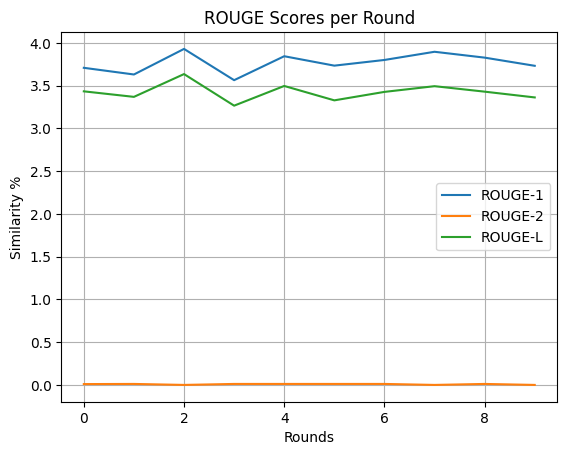

In [20]:
r1_plot = []
r2_plot = []
rl_plot = []
leven_plot = []
word2v_plot = []

for i in range(10):
    r1_plot.append(sum(rouge_1[i]) / len(rouge_1[i]))
    r2_plot.append(sum(rouge_2[i]) / len(rouge_2[i]))
    rl_plot.append(sum(rouge_l[i]) / len(rouge_l[i]))
    leven_plot.append(sum(leven[i]) / len(leven[i]))
    word2v_plot.append(sum(word2v[i]) / len(word2v[i]))
    
plot_data = {'ROUGE-1': r1_plot,'ROUGE-2': r2_plot,'ROUGE-L':rl_plot,}


import matplotlib.pyplot as plt
fig, ax = plt.subplots()
for dat in plot_data.keys():
    ax.plot([0,1,2,3,4,5,6,7,8,9], plot_data[dat], label=dat)
ax.set(ylabel='Similarity %', xlabel='Rounds', title='ROUGE Scores per Round')
ax.grid()
    
plt.legend()
    
plt.show()


    # 

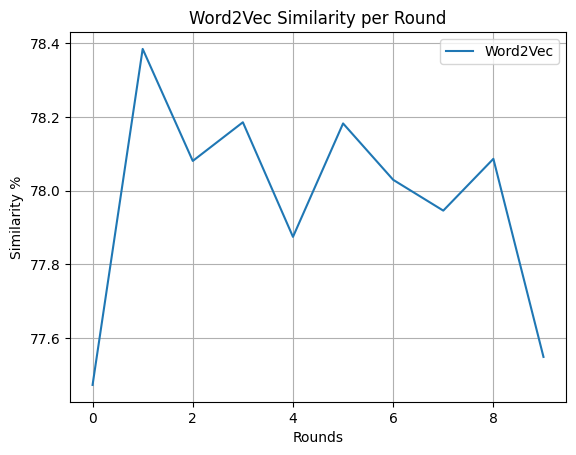

In [21]:
plot_data = {'Word2Vec':word2v_plot}
# 'Word2Vec':word2v_plot
# 'Norm Levenshtein':leven_plot, 

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
for dat in plot_data.keys():
    ax.plot([0,1,2,3,4,5,6,7,8,9], plot_data[dat], label=dat)
ax.set(ylabel='Similarity %', xlabel='Rounds', title='Word2Vec Similarity per Round')
ax.grid()
    
plt.legend()
    
plt.show()

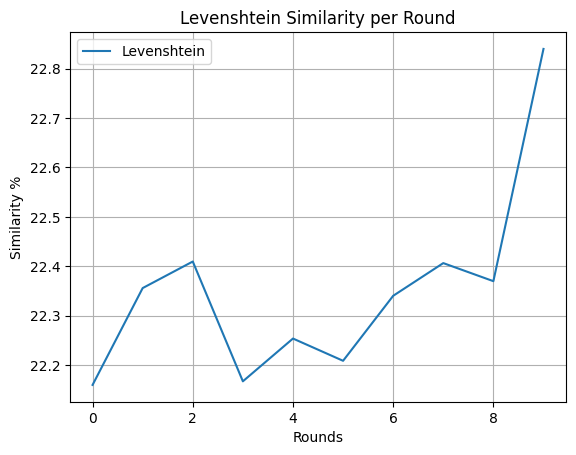

In [22]:
plot_data = {'Levenshtein':leven_plot}

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
for dat in plot_data.keys():
    ax.plot([0,1,2,3,4,5,6,7,8,9], plot_data[dat], label=dat)
ax.set(ylabel='Similarity %', xlabel='Rounds', title='Levenshtein Similarity per Round')
ax.grid()
    
plt.legend()
    
plt.show()